# MadMiner particle physics tutorial

# Part A4: Likelihood Module: no systematics

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this notebook, we use the Likelihood class for a process without any systematics. 

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

from madminer import NeuralLikelihood, HistoLikelihood, project_log_likelihood, profile_log_likelihood
from madminer import AsymptoticLimits, plot_pvalue_limits

ImportError: dlopen(/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/scipy/special/_ufuncs.so, 2): Library not loaded: @rpath/libgfortran.3.dylib
  Referenced from: /Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/scipy/special/_ufuncs.so
  Reason: image not found

We define the grid and luminosity 

In [ ]:
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [10, 10]

In [ ]:
lumi = 300.*1000. 
n_asimov=10000
n_histo_toys=50000

In [2]:
do_load=True

if do_load:
    p_values,mle,durations = np.load("limits/c1.npy")
else:
    p_values = {}
    mle = {}
    durations = {}

IOError: [Errno 2] No such file or directory: u'limits/c1.npy'

## 1. Using AsymptoticLimits class

For comparisson, let's use the `AsymptoticLimits` class again. 

In [5]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')

20:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:04 madminer.analysis    INFO    Found 2 parameters
20:04 madminer.analysis    INFO    Did not find nuisance parameters
20:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:04 madminer.analysis    INFO    Found 3 observables
20:04 madminer.analysis    INFO    Found 539913 events
20:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:04 madminer.analysis    INFO    Found morphing setup with 6 components
20:04 madminer.analysis    INFO    Did not find nuisance morphing setup


Now we calculate the limits for the choosen grid using
- the full likelihood ratio estimated by the ALICES method
- the score estimated using the SALLY method
- a "pt_j1" histogram with fixed bins
- the rate 

### a) ALICES 

In [6]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
)
duration = time.time()-start_time

p_values["AL: ALICES"] = p_values_expected
mle["AL: ALICES"] = best_fit_expected
durations["AL: ALICES"] = duration

20:04 madminer.limits      INFO    Generating Asimov data
20:04 madminer.limits      INFO    Expected events: 313.1522825343162
20:04 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode ml without rate information
20:04 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:04 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
20:04 madminer.ml          INFO    Loading model from models/alices
20:04 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
20:04 madminer.limits      INFO    Calculating p-values


### b) SALLY

In [7]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
    hist_bins=[5,5],
)
duration = time.time()-start_time

p_values["AL: SALLY"] = p_values_expected
mle["AL: SALLY"] = best_fit_expected
durations["AL: SALLY"] = duration

20:04 madminer.limits      INFO    Generating Asimov data
20:04 madminer.limits      INFO    Expected events: 313.1522825343162
20:04 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode sally without rate information
20:04 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:04 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:04 madminer.ml          INFO    Loading model from models/sally
20:04 madminer.limits      INFO    Creating histograms of 2 summary statistics. Using [5, 5] bins each, or 25 in total.
20:04 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:04 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:04 madminer.limits      INFO    Calculating p-values


### c) Histogram

In [8]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
)
duration = time.time()-start_time

p_values["AL: Histo"] = p_values_expected
mle["AL: Histo"] = best_fit_expected
durations["AL: Histo"] = duration

20:04 madminer.limits      INFO    Generating Asimov data
20:04 madminer.limits      INFO    Expected events: 313.1522825343162
20:04 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode histo without rate information
20:04 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:04 madminer.limits      INFO    Setting up standard summary statistics
20:04 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using [5] bins each, or 5 in total.
20:04 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:04 madminer.limits      INFO    Calculating p-values


### d) Rate

In [9]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="rate",
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=True,
)
duration = time.time()-start_time

p_values["AL: Rate"] = p_values_expected
mle["AL: Rate"] = best_fit_expected
durations["AL: Rate"] = duration

20:04 madminer.limits      INFO    Generating Asimov data
20:04 madminer.limits      INFO    Expected events: 313.1522825343162
20:04 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode rate including rate information
20:04 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:04 madminer.limits      INFO    Calculating rate log likelihood
20:04 madminer.limits      INFO    Calculating p-values


## 2. Using Likelihood class - Weighted

We can also use the new Likelihood class to obtain limits. There are to main classes, the `NeuralLikelihood` and `HistoLikelihood` class. First, let's initialize both classes

In [10]:
neurallikelihood = NeuralLikelihood("data/lhe_data_shuffled.h5")
histolikelihood = HistoLikelihood("data/lhe_data_shuffled.h5")

20:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:04 madminer.analysis    INFO    Found 2 parameters
20:04 madminer.analysis    INFO    Did not find nuisance parameters
20:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:04 madminer.analysis    INFO    Found 3 observables
20:04 madminer.analysis    INFO    Found 539913 events
20:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:04 madminer.analysis    INFO    Found morphing setup with 6 components
20:04 madminer.analysis    INFO    Did not find nuisance morphing setup
20:04 madminer.analysis    INFO    Loading dat

We can now create a function which returns the expected negative log likelihood $-\mathrm{E}[\log p(x|\theta) | \theta_{\text{true}}]$ using the function `create_expected_negative_log_likelihood()`. This function is evaluated in a grid using `project_log_likelihood()`. Let us again do this for ALICES, SALLY, a histogram and the rate.

**Note:** Here we use the `sampled` mode when calculating the likelihood function. This means that at every point we separatly evaulate the rate and sample a set of events to fill histograms. This setup is therefore expected to be slow. 

### a) ALICES

In [11]:
start_time = time.time()
nll_alices = neurallikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    model_file="models/alices",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_alices,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: ALICES"] = p_values_expected
mle["LHS: ALICES"] = best_fit_expected
durations["LHS: ALICES"] = duration

20:04 madminer.ml          INFO    Loading model from models/alices


### b) SALLY

In [12]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: SALLY"] = p_values_expected
mle["LHS: SALLY"] = best_fit_expected
durations["LHS: SALLY"] = duration

20:04 madminer.ml          INFO    Loading model from models/sally
20:04 madminer.likelihood  INFO    Setting up standard summary statistics
20:04 madminer.likelihood  INFO    Setting up binning
20:05 madminer.likelihood  INFO    Use binning: [array([-6.84291836, -0.14816707,  0.09972289,  0.22996766,  0.30907326,
        0.37738783]), array([-3.41586907, -0.33438505, -0.1014865 ,  0.11385787,  0.34599706,
        3.67435363])]
20:05 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:05 madminer.analysis    INFO    Found 2 parameters
20:05 madminer.analysis    INFO    Did not find nuisance parameters
20:05 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:05 madminer.analysis    INFO    Found 3 observables
20:05 madminer.analysis    INFO    Found 539913 events
20:05 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:05 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:05 madminer.a

20:06 madminer.analysis    INFO    Found 3 observables
20:06 madminer.analysis    INFO    Found 539913 events
20:06 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:06 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:06 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:06 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:06 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:06 madminer.analysis    INFO    Found morphing setup with 6 components
20:06 madminer.analysis    INFO    Did not find nuisance morphing setup
20:06 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-1.          0.11111111]
20:06 madminer.sampling    INFO    Starting sampling serially
20:06 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:06 madminer.sampling    INFO    Effective number of samples: mean 553

20:08 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:08 madminer.analysis    INFO    Found 2 parameters
20:08 madminer.analysis    INFO    Did not find nuisance parameters
20:08 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:08 madminer.analysis    INFO    Found 3 observables
20:08 madminer.analysis    INFO    Found 539913 events
20:08 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:08 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:08 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:08 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:08 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:08 madminer.analysis    INFO    Found morphing setup with 6 components
20:08 madminer.analysis    INFO    Did not find nuisance morphing setup
20:08 madminer.sampling    INFO    Extracting 

20:10 madminer.analysis    INFO    Did not find nuisance morphing setup
20:10 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778  0.33333333]
20:10 madminer.sampling    INFO    Starting sampling serially
20:10 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:10 madminer.sampling    INFO    Effective number of samples: mean 838.93835804063, with individual thetas ranging from 838.9383580406295 to 838.9383580406295
20:10 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:10 madminer.analysis    INFO    Found 2 parameters
20:10 madminer.analysis    INFO    Did not find nuisance parameters
20:10 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:10 madminer.analysis    INFO    Found 3 observables
20:10 madminer.analysis    INFO    Found 539913 events
20:10 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:10 madminer.analysis    INFO      10000 sign

20:11 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:11 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:11 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:11 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:11 madminer.analysis    INFO    Found morphing setup with 6 components
20:11 madminer.analysis    INFO    Did not find nuisance morphing setup
20:11 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.55555556]
20:11 madminer.sampling    INFO    Starting sampling serially
20:11 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:11 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.5555556]: (0.001375 +/- 0.000145) pb (10.542631892100937 %). Skipping these warnings in the future...
20:11 madminer.sampling    INF

20:13 madminer.analysis    INFO    Found 3 observables
20:13 madminer.analysis    INFO    Found 539913 events
20:13 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:13 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:13 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:13 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:13 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:13 madminer.analysis    INFO    Found morphing setup with 6 components
20:13 madminer.analysis    INFO    Did not find nuisance morphing setup
20:13 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556  0.77777778]
20:13 madminer.sampling    INFO    Starting sampling serially
20:13 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:13 madminer.sampling    INFO    Effective number of samples: mean 586

20:15 madminer.sampling    INFO    Effective number of samples: mean 1061.3760636451223, with individual thetas ranging from 1061.376063645122 to 1061.376063645122
20:15 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:15 madminer.analysis    INFO    Found 2 parameters
20:15 madminer.analysis    INFO    Did not find nuisance parameters
20:15 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:15 madminer.analysis    INFO    Found 3 observables
20:15 madminer.analysis    INFO    Found 539913 events
20:15 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:15 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:15 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:15 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:15 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:15 madminer.analysis    I

20:17 madminer.sampling    INFO    Effective number of samples: mean 380.58851744002925, with individual thetas ranging from 380.58851744002925 to 380.58851744002925
20:17 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:17 madminer.analysis    INFO    Found 2 parameters
20:17 madminer.analysis    INFO    Did not find nuisance parameters
20:17 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:17 madminer.analysis    INFO    Found 3 observables
20:17 madminer.analysis    INFO    Found 539913 events
20:17 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:17 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:17 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:17 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:17 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:17 madminer.analysis   

20:19 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:19 madminer.analysis    INFO    Found morphing setup with 6 components
20:19 madminer.analysis    INFO    Did not find nuisance morphing setup
20:19 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111  0.11111111]
20:19 madminer.sampling    INFO    Starting sampling serially
20:19 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:19 madminer.sampling    INFO    Effective number of samples: mean 16640.357355517426, with individual thetas ranging from 16640.357355517433 to 16640.357355517433
20:19 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:19 madminer.analysis    INFO    Found 2 parameters
20:19 madminer.analysis    INFO    Did not find nuisance parameters
20:19 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:19 madminer.analysis    INFO    Found 3 observables
20:19 madminer.analy

20:21 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:21 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:21 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:21 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:21 madminer.analysis    INFO    Found morphing setup with 6 components
20:21 madminer.analysis    INFO    Did not find nuisance morphing setup
20:21 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.11111111 -0.77777778]
20:21 madminer.sampling    INFO    Starting sampling serially
20:21 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:21 madminer.sampling    INFO    Effective number of samples: mean 461.5015461060185, with individual thetas ranging from 461.50154610601857 to 461.50154610601857
20:21 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:21 madminer.analysi

20:22 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:22 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:22 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:22 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:22 madminer.analysis    INFO    Found morphing setup with 6 components
20:22 madminer.analysis    INFO    Did not find nuisance morphing setup
20:22 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.11111111 0.55555556]
20:22 madminer.sampling    INFO    Starting sampling serially
20:22 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:22 madminer.sampling    INFO    Effective number of samples: mean 770.1659563953114, with individual thetas ranging from 770.1659563953115 to 770.1659563953115
20:23 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:23 madminer.analysis   

20:24 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:24 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:24 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:24 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:24 madminer.analysis    INFO    Found morphing setup with 6 components
20:24 madminer.analysis    INFO    Did not find nuisance morphing setup
20:24 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -0.33333333]
20:24 madminer.sampling    INFO    Starting sampling serially
20:24 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:24 madminer.sampling    INFO    Effective number of samples: mean 1786.1823126895838, with individual thetas ranging from 1786.1823126895845 to 1786.1823126895845
20:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:25 madminer.analys

20:26 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:26 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:26 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:26 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:26 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:26 madminer.analysis    INFO    Found morphing setup with 6 components
20:26 madminer.analysis    INFO    Did not find nuisance morphing setup
20:26 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.33333333 1.        ]
20:26 madminer.sampling    INFO    Starting sampling serially
20:26 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:26 madminer.sampling    INFO    Effective number of samples: mean 225.59030037427473, with individual thetas ranging from 225.59030037427482 to 225.59030037427482
20:26 madminer.ana

20:28 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:28 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:28 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:28 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:28 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:28 madminer.analysis    INFO    Found morphing setup with 6 components
20:28 madminer.analysis    INFO    Did not find nuisance morphing setup
20:28 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.11111111]
20:28 madminer.sampling    INFO    Starting sampling serially
20:28 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:28 madminer.sampling    INFO    Effective number of samples: mean 875.4727612540099, with individual thetas ranging from 875.4727612540099 to 875.4727612540099
20:28 madminer.analys

20:30 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:30 madminer.analysis    INFO    Found 3 observables
20:30 madminer.analysis    INFO    Found 539913 events
20:30 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:30 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:30 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:30 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:30 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:30 madminer.analysis    INFO    Found morphing setup with 6 components
20:30 madminer.analysis    INFO    Did not find nuisance morphing setup
20:30 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.77777778]
20:30 madminer.sampling    INFO    Starting sampling serially
20:30 madminer.sampling    INFO    Sampling from parameter point 1 /

20:32 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:32 madminer.analysis    INFO    Found 3 observables
20:32 madminer.analysis    INFO    Found 539913 events
20:32 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:32 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:32 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:32 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:32 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:32 madminer.analysis    INFO    Found morphing setup with 6 components
20:32 madminer.analysis    INFO    Did not find nuisance morphing setup
20:32 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.77777778 0.55555556]
20:32 madminer.sampling    INFO    Starting sampling serially
20:32 madminer.sampling    INFO    Sampling from parameter point 1 / 1

20:33 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:33 madminer.sampling    INFO    Effective number of samples: mean 316.7951624145367, with individual thetas ranging from 316.79516241453666 to 316.79516241453666
20:34 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:34 madminer.analysis    INFO    Found 2 parameters
20:34 madminer.analysis    INFO    Did not find nuisance parameters
20:34 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:34 madminer.analysis    INFO    Found 3 observables
20:34 madminer.analysis    INFO    Found 539913 events
20:34 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:34 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:34 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:34 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:34 madminer.analysis    INFO      10000 

20:35 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:35 madminer.analysis    INFO    Found morphing setup with 6 components
20:35 madminer.analysis    INFO    Did not find nuisance morphing setup
20:35 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [1.         0.77777778]
20:35 madminer.sampling    INFO    Starting sampling serially
20:35 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:35 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [1.        0.7777778]: (0.000995 +/- 0.000141) pb (14.147458776395247 %). Skipping these warnings in the future...
20:35 madminer.sampling    INFO    Effective number of samples: mean 141.2520133803712, with individual thetas ranging from 141.25201338037127 to 141.25201338037127
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 

### c) Histogram

In [13]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: Histo"] = p_values_expected
mle["LHS: Histo"] = best_fit_expected
durations["LHS: Histo"] = duration

20:36 madminer.likelihood  INFO    Setting up standard summary statistics
20:36 madminer.likelihood  INFO    Setting up binning
20:36 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from b

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-1.          0.11111111]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 553.2125757107707, with individual thetas ranging from 553.2125757107709 to 553.2125757107709
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis 

20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778 -0.77777778]
20:36 madminer.sampling    INFO    Starting sampling serially


20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 838.93835804063, with individual thetas ranging from 838.9383580406295 to 838.9383580406295
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled fro

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.55555556]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.5555556]: (0.001375 +/- 0.000145) pb (10.542631892100937 %). Skipping these warnings in the future...
20:36 madminer.sampling    INFO    Effective number of samples: mean 448.92424179593206, with individual thetas ranging from 448.92424179593183 to 448.92424179593183
20:36 madminer.analysis    INFO 

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556  0.77777778]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 586.091296042241, with individual thetas ranging from 586.0912960422409 to 586.0912960422409
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis  

20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting 

20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting 

20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111  0.11111111]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 16640.357355517426, with individual thetas ranging from 16640.357355517433 to 16640.357355517433
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.11111111 -0.77777778]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 461.5015461060185, with individual thetas ranging from 461.50154610601857 to 461.50154610601857
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 ph

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.11111111 0.55555556]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 770.1659563953114, with individual thetas ranging from 770.1659563953115 to 770.1659563953115
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physic

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -0.33333333]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 1786.1823126895838, with individual thetas ranging from 1786.1823126895845 to 1786.1823126895845
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 p

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.33333333 1.        ]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 225.59030037427473, with individual thetas ranging from 225.59030037427482 to 225.59030037427482
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nui

20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.11111111]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 875.4727612540099, with individual thetas ranging from 875.4727612540099 to 875.4727612540099
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisan

20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.77777778]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 339.22668928159624, with individual thetas ranging from 33

20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.77777778 0.55555556]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    INFO    Effective number of samples: mean 239.7732944516593, with individual thetas ranging from 239.7

20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysis    INFO    Found 539913 events
20:36 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:36 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:36 madminer.analysis    INFO    Found morphing setup with 6 components
20:36 madminer.analysis    INFO    Did not find nuisance morphing setup
20:36 madminer.sampling    INFO    Extracting 

20:36 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [1.         0.77777778]
20:36 madminer.sampling    INFO    Starting sampling serially
20:36 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:36 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [1.        0.7777778]: (0.000995 +/- 0.000141) pb (14.147458776395247 %). Skipping these warnings in the future...
20:36 madminer.sampling    INFO    Effective number of samples: mean 141.2520133803712, with individual thetas ranging from 141.25201338037127 to 141.25201338037127
20:36 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:36 madminer.analysis    INFO    Found 2 parameters
20:36 madminer.analysis    INFO    Did not find nuisance parameters
20:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:36 madminer.analysis    INFO    Found 3 observables
20:36 madminer.analysi

### d) Rate

In [14]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="sampled",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: Rate"] = p_values_expected
mle["LHS: Rate"] = best_fit_expected
durations["LHS: Rate"] = duration

20:36 madminer.likelihood  INFO    No observables and scores provided. Calculate LLR due to rate and set include_xsec=True.
20:36 madminer.likelihood  INFO    Setting up standard summary statistics
20:36 madminer.likelihood  INFO    Setting up binning
20:36 madminer.likelihood  INFO    Use binning: None


## 3. Using Likelihood class - Unweighted

How let's use the `mode=weighted` mode when calculating the likelihood function. This means that we first create a set of unweighted events. Later, these events are used to calculate the cross section and create the histograms for each parameter point. This setup is expected to be faster. 

### a) ALICES

In [15]:
start_time = time.time()
nll_alices = neurallikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    model_file="models/alices",
    mode="weighted",
    n_weighted=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_alices,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: ALICES"] = p_values_expected
mle["LHW: ALICES"] = best_fit_expected
durations["LHW: ALICES"] = duration

20:36 madminer.ml          INFO    Loading model from models/alices


### b) SALLY

In [16]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: SALLY"] = p_values_expected
mle["LHW: SALLY"] = best_fit_expected
durations["LHW: SALLY"] = duration

20:37 madminer.ml          INFO    Loading model from models/sally
20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: [array([-7.31596707, -0.14345846,  0.10058699,  0.22946604,  0.31041272,
        0.37705326]), array([-3.32069593, -0.34406366, -0.10538475,  0.11455534,  0.34237415,
        3.83437803])]


### c) Histogram

In [17]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: Histo"] = p_values_expected
mle["LHW: Histo"] = best_fit_expected
durations["LHW: Histo"] = duration

20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]


### d) Rate

In [18]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: Rate"] = p_values_expected
mle["LHW: Rate"] = best_fit_expected
durations["LHW: Rate"] = duration

20:37 madminer.likelihood  INFO    No observables and scores provided. Calculate LLR due to rate and set include_xsec=True.
20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: None


## 4. Using Likelihood class - Histograms

Finally, we can use the `mode=histo` mode when calculating the likelihood function. This options first creates histograms for each morphing benchmarks, which are later morphed to create the histograms for each parameter point. This setup is expected to be the fastest, especially when there are a large number of grid points at which the likelihood has to be evaulated. 

**Note:** Currently, this mode doesn't support nuissance parameter. 

### a) SALLY 

In [19]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="histo",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHH: SALLY"] = p_values_expected
mle["LHH: SALLY"] = best_fit_expected
durations["LHH: SALLY"] = duration

20:37 madminer.ml          INFO    Loading model from models/sally
20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: [array([-7.73806016, -0.14142476,  0.10339331,  0.22725957,  0.30809923,
        0.37746276]), array([-3.38298333, -0.34644834, -0.10689301,  0.11544048,  0.34967544,
        3.79733702])]


### b) Histogram 

In [20]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="histo",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHH: Histo"] = p_values_expected
mle["LHH: Histo"] = best_fit_expected
durations["LHH: Histo"] = duration

20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]


### c) Rate 

In [21]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="histo",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHH: Rate"] = p_values_expected
mle["LHH: Rate"] = best_fit_expected
durations["LHH: Rate"] = duration

20:37 madminer.likelihood  INFO    No observables and scores provided. Calculate LLR due to rate and set include_xsec=True.
20:37 madminer.likelihood  INFO    Setting up standard summary statistics
20:37 madminer.likelihood  INFO    Getting weighted data
20:37 madminer.likelihood  INFO    Setting up binning
20:37 madminer.likelihood  INFO    Use binning: None


## 5. Plot Results

Let's plot the results:

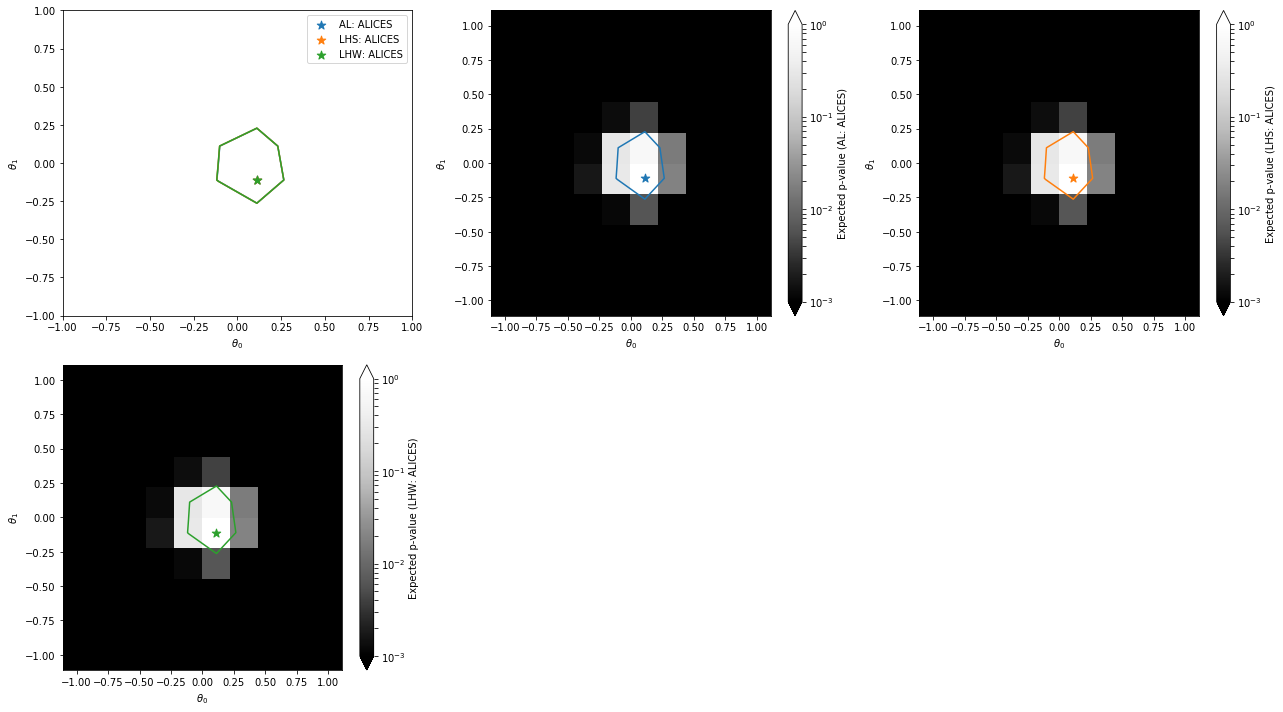

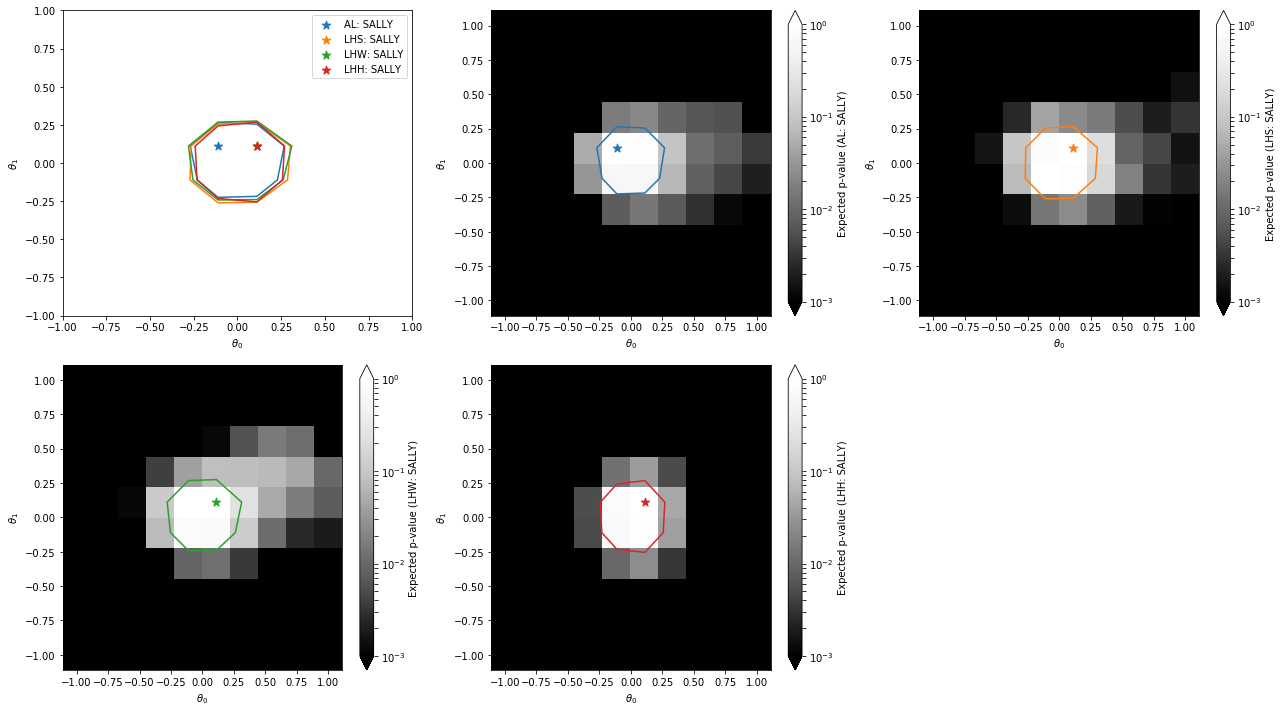

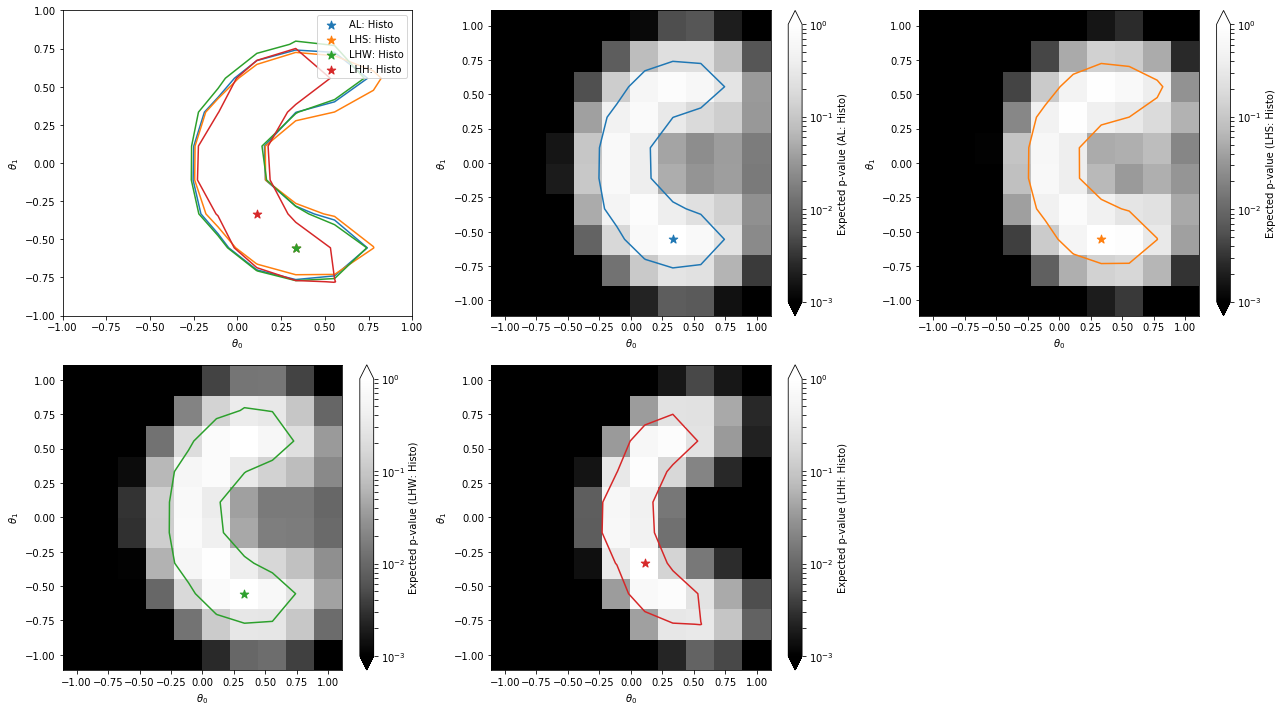

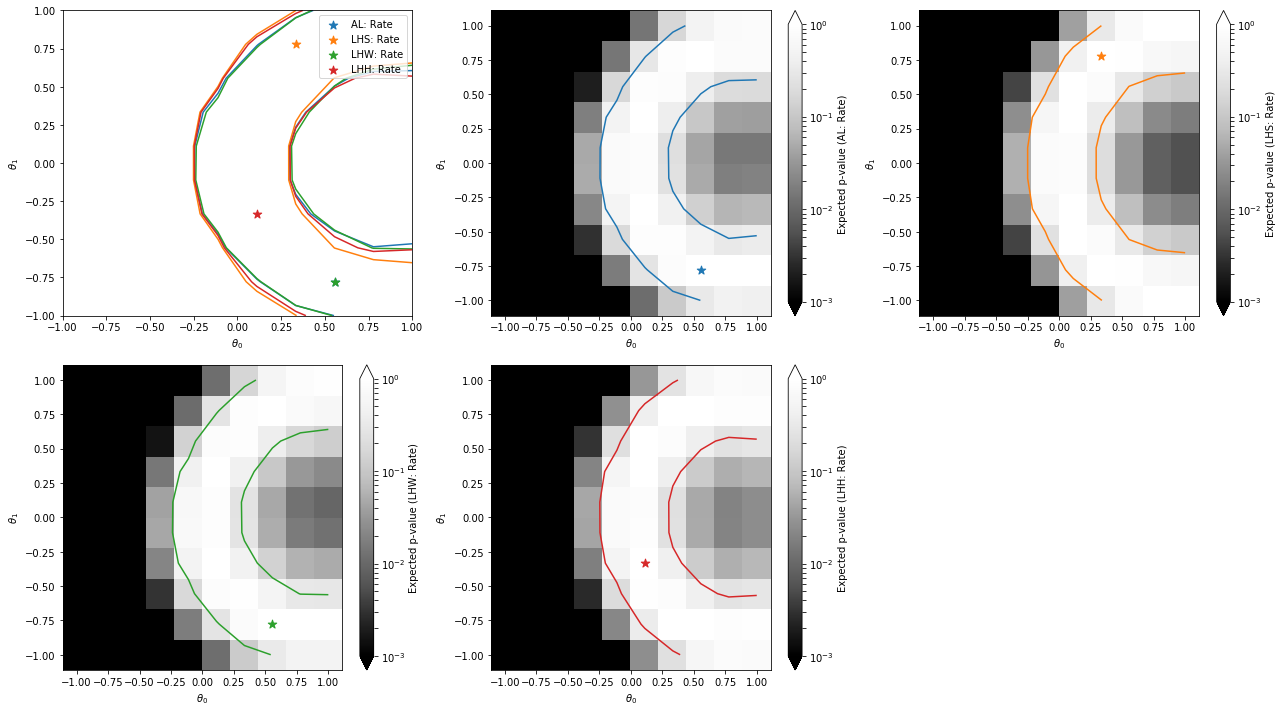

In [22]:
plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: ALICES",  "LHS: ALICES", "LHW: ALICES"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: SALLY",  "LHS: SALLY", "LHW: SALLY", "LHH: SALLY"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: Histo",  "LHS: Histo", "LHW: Histo", "LHH: Histo"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: Rate",  "LHS: Rate", "LHW: Rate", "LHH: Rate"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

We can also look at the computation time:

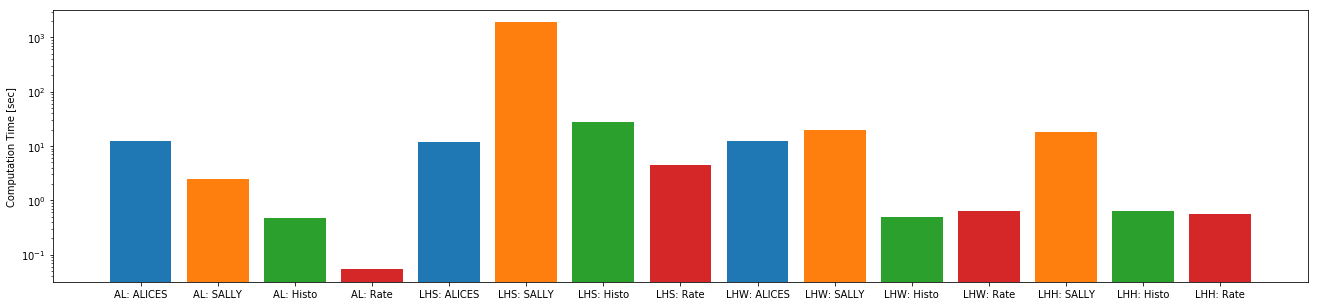

In [23]:
labels = ["AL: ALICES", "AL: SALLY", "AL: Histo", "AL: Rate", "LHS: ALICES", "LHS: SALLY", "LHS: Histo", "LHS: Rate",
            "LHW: ALICES", "LHW: SALLY", "LHW: Histo", "LHW: Rate", "LHH: SALLY", "LHH: Histo", "LHH: Rate"]
colors=['C0','C1','C2','C3','C0','C1','C2','C3','C0','C1','C2','C3','C1','C2','C3']
times = [durations[str(label)] for label in labels]
indices = [i for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(1.5*len(labels),5))
plt.bar(indices, times,color=colors)
plt.xticks(indices, labels)
plt.yscale("log")
plt.ylabel("Computation Time [sec]")
plt.show()

In [24]:
# np.save("limits/c1.npy",[p_values,mle,durations])

## 6. Profile over one parameter

Let's look more closely rate. At first we calculate the expected p-value in a grid.

In [25]:
grid_ranges_rate = [(-1, 3.), (-1, 1.)]
grid_resolutions_rate = [20, 10]
theta_grid_rate, p_values_expected_rate, mle_rate , _ = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
)

We can also profile over a parameter using the function `profile_log_likelihood` to profile over the rate only likelihood function.

In [26]:
theta_grid_proj, p_values_expected_proj, best_fit_expected_proj, llr_proj = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
)
theta_grid_prof, p_values_expected_prof, best_fit_expected_prof, llr_prof = profile_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
    theta_start=np.array([0,0])
)

20:37 madminer.likelihood  INFO    Processed 1.0 % of parameter points in 0.4 seconds.
20:37 madminer.likelihood  INFO    Processed 2.0 % of parameter points in 0.7 seconds.
20:37 madminer.likelihood  INFO    Processed 4.0 % of parameter points in 0.9 seconds.
20:37 madminer.likelihood  INFO    Processed 6.0 % of parameter points in 1.5 seconds.
20:38 madminer.likelihood  INFO    Processed 8.0 % of parameter points in 1.8 seconds.
20:38 madminer.likelihood  INFO    Processed 20.0 % of parameter points in 3.9 seconds.
20:38 madminer.likelihood  INFO    Processed 30.0 % of parameter points in 5.9 seconds.
20:38 madminer.likelihood  INFO    Processed 40.0 % of parameter points in 8.5 seconds.
20:38 madminer.likelihood  INFO    Processed 50.0 % of parameter points in 11.0 seconds.
20:38 madminer.likelihood  INFO    Processed 60.0 % of parameter points in 13.2 seconds.
20:38 madminer.likelihood  INFO    Processed 70.0 % of parameter points in 15.3 seconds.
20:38 madminer.likelihood  INFO   

Let's now plot both the 2-dimensional and 1-dimensional result.

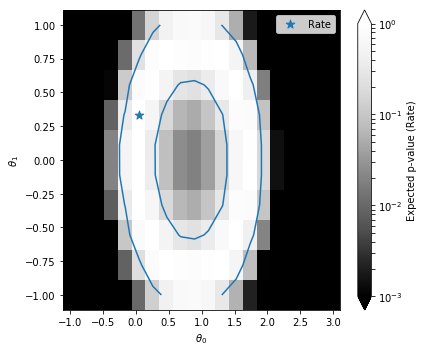

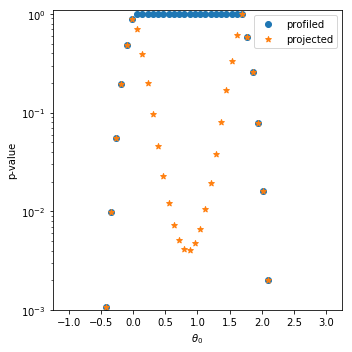

In [27]:
plot_pvalue_limits(
    p_values=np.array([p_values_expected_rate]),
    best_fits=np.array([mle_rate]),
    labels=["Rate"],
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
    show_index=0,
)

fig = plt.figure(figsize=(5,5))
plt.scatter(theta_grid_prof,p_values_expected_prof,label="profiled")
plt.scatter(theta_grid_proj,p_values_expected_proj,label="projected",marker="*")
plt.xlabel(r"$\theta_0$")
plt.ylabel("p-value")
plt.yscale("log")
plt.ylim(0.001,1.1)
plt.legend()
plt.tight_layout()
plt.show()

We can see that 2-dimensional has the shape of a donut - it has a blind direction where the rate is unchanged. If we project the likelihood in one dimension (so set the other parameter to zero) we obtain a double peak structue. However, if we properly profile of the other component, we get a plateau. This reflects that in the platau region we can find a value of $\theta$ that leads to the same rate and hence same likelihood as the SM reference point. 